# Vision Transformer

Using device: cuda


c:\Users\HP\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\HP\anaconda3\Lib\site-packages\transformers\models\vit\modeling_vit.py:253: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runne

Best model saved at epoch 1
Epoch [1/10]:
  Train Loss: 0.0273, Train Accuracy: 0.9879
  Val Loss: 0.1191, Val Accuracy: 0.9667
----------------------------------------
Epoch [2/10]:
  Train Loss: 0.0001, Train Accuracy: 1.0000
  Val Loss: 0.1310, Val Accuracy: 0.9667
----------------------------------------
Best model saved at epoch 3
Epoch [3/10]:
  Train Loss: 0.0000, Train Accuracy: 1.0000
  Val Loss: 0.1284, Val Accuracy: 0.9683
----------------------------------------
Best model saved at epoch 4
Epoch [4/10]:
  Train Loss: 0.0000, Train Accuracy: 1.0000
  Val Loss: 0.1270, Val Accuracy: 0.9717
----------------------------------------
Best model saved at epoch 5
Epoch [5/10]:
  Train Loss: 0.0000, Train Accuracy: 1.0000
  Val Loss: 0.1257, Val Accuracy: 0.9733
----------------------------------------
Epoch [6/10]:
  Train Loss: 0.0000, Train Accuracy: 1.0000
  Val Loss: 0.1247, Val Accuracy: 0.9733
----------------------------------------
Epoch [7/10]:
  Train Loss: 0.0000, Train 

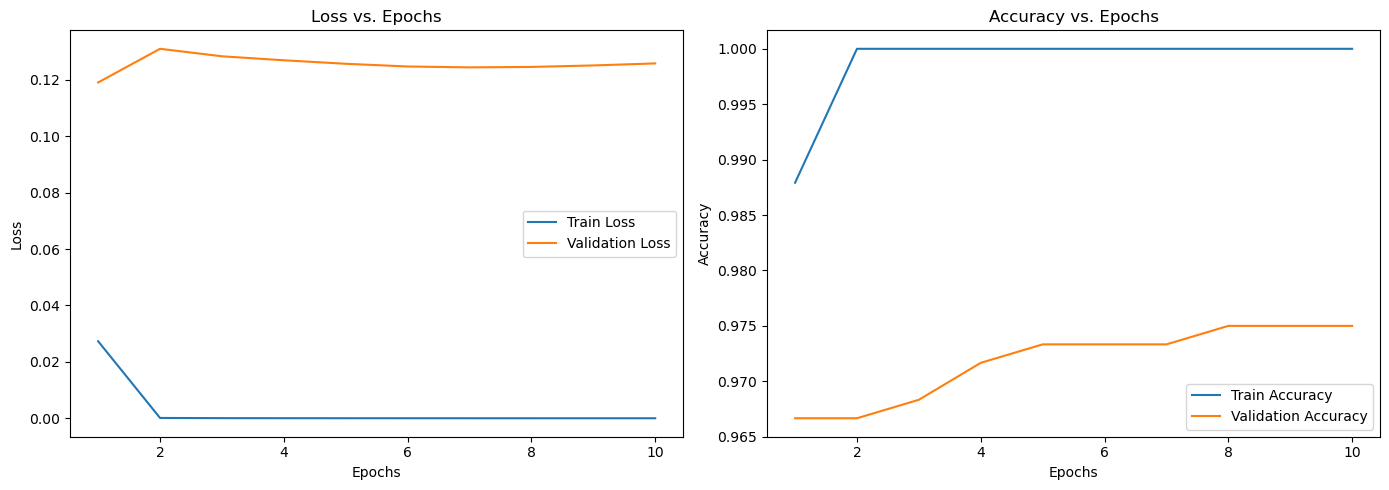

Training Complete. Plots saved as JPG.


In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, AutoImageProcessor
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Set paths
train_path = 'F:/Volcanic Activity Detection/LastUpdate/train'
test_path = 'F:/Volcanic Activity Detection/LastUpdate/test'

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set manual seed for reproducibility
torch.manual_seed(42)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize Vision Transformer model
model_name = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)

# Replace classifier head (optional, already handled by num_labels)
model.classifier = nn.Linear(model.config.hidden_size, 2)
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop with plotting and saving plots as JPG
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy calculation
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = train_correct / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy calculation
                val_correct += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = val_correct / total_val
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(val_accuracy)

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "Vision Transformer for Volcanic Activity Detection_best.pth")
            print(f"Best model saved at epoch {epoch + 1}")

        print(f"Epoch [{epoch + 1}/{epochs}]:")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
        print("-" * 40)

    # Save the final model
    torch.save(model.state_dict(), "Vision Transformer for Volcanic Activity Detection_final.pth")
    print("Final model saved.")

    # Plot the accuracy and loss graphs
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.legend()

    plt.tight_layout()
    plot_path = "F:/Volcanic Activity Detection/"
    plt.savefig(os.path.join(plot_path, "training_plots_vit.jpg"), format="jpg")
    plt.show()

    print("Training Complete. Plots saved as JPG.")

# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Train and evaluate
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

## ViT Model Classification Report

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, AutoImageProcessor
from sklearn.metrics import classification_report

# Set paths
test_path = 'F:/Volcanic Activity Detection/LastUpdate/test'
model_path = "Vision Transformer for Volcanic Activity Detection_best.pth"

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load test dataset
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the saved Vision Transformer model
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)

# Replace classifier head (optional, already handled by num_labels)
model.classifier = torch.nn.Linear(model.config.hidden_size, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Evaluation loop
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Run evaluation
print("Evaluating the model on the test dataset...")
evaluate_model(model, test_loader)


Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_23428\1767676425.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` 

Evaluating the model on the test dataset...


c:\Users\HP\anaconda3\Lib\site-packages\transformers\models\vit\modeling_vit.py:253: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(



Classification Report:
              precision    recall  f1-score   support

  NoActivity       0.95      1.00      0.98       300
 YesActivity       1.00      0.95      0.97       300

    accuracy                           0.97       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.98      0.97      0.97       600



Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_23428\359254372.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` w

Evaluating the model on the test dataset...

Classification Report:
              precision    recall  f1-score   support

  NoActivity       0.95      1.00      0.98       300
 YesActivity       1.00      0.95      0.97       300

    accuracy                           0.97       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.98      0.97      0.97       600



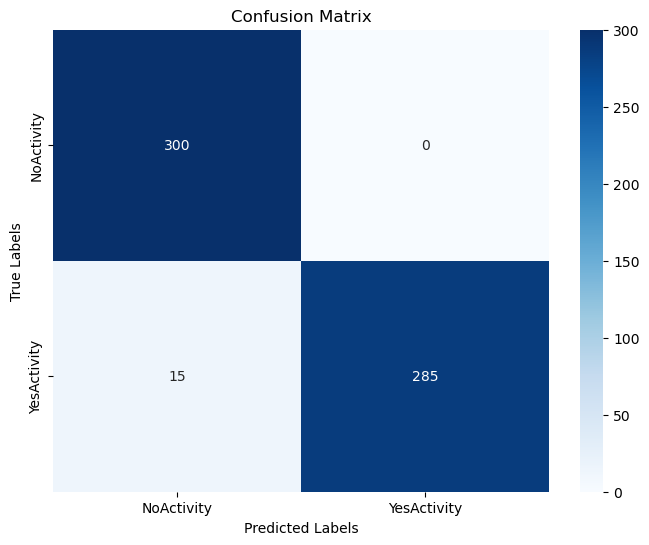

In [7]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, AutoImageProcessor
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set paths
test_path = 'F:/Volcanic Activity Detection/LastUpdate/test'
model_path = "Vision Transformer for Volcanic Activity Detection_best.pth"

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load test dataset
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the saved Vision Transformer model
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)

# Replace classifier head (optional, already handled by num_labels)
model.classifier = torch.nn.Linear(model.config.hidden_size, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Evaluation loop
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, test_dataset.classes)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
print("Evaluating the model on the test dataset...")
evaluate_model(model, test_loader)


## Explainable AI

Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\AppData\Local\Temp\ipykernel_14372\1831356075.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` 

Predicted Class: YesActivity with probabilities: [[1.106787e-06 9.999989e-01]]


  0%|          | 0/1000 [00:00<?, ?it/s]

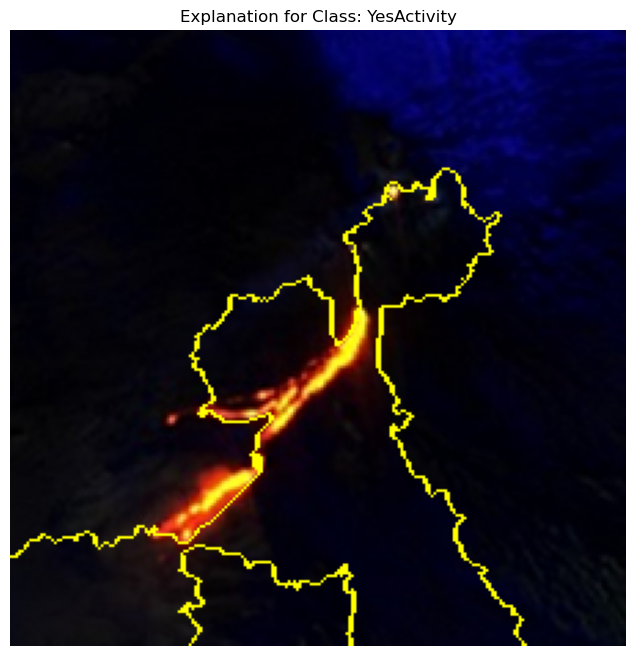

In [2]:
import torch
import torchvision.transforms as transforms
from transformers import ViTForImageClassification
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image

# Set paths
image_path = r'F:\Volcanic Activity Detection\LastUpdate\test\YesActivity\YesActivity_original_Image12.png_1acdc754-9dee-4c74-8684-6c9209d8d255.png'  # Path to your specific image
model_path = "Vision Transformer for Volcanic Activity Detection_best.pth"

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the saved Vision Transformer model
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True
)

model.classifier = torch.nn.Linear(model.config.hidden_size, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Helper function for LIME predictions
def predict_proba(images):
    model.eval()
    images_tensor = torch.stack([
        transform(Image.fromarray(image)).unsqueeze(0).to(device) for image in images
    ]).squeeze(1)  # Ensure correct dimensions for batch processing
    with torch.no_grad():
        outputs = model(images_tensor).logits
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probs

# Load your specific image
pil_image = Image.open(image_path).convert('RGB')  # Ensure the image is RGB
transformed_image = transform(pil_image).unsqueeze(0).to(device)

# Get the model's prediction
model.eval()
with torch.no_grad():
    logits = model(transformed_image).logits
    probs = torch.nn.functional.softmax(logits, dim=1)
predicted_class = torch.argmax(probs, dim=1).item()
class_names = ['NoActivity', 'YesActivity']  # Update with your class names if needed
true_label = class_names[predicted_class]

print(f"Predicted Class: {true_label} with probabilities: {probs.cpu().numpy()}")

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the model's prediction
explanation = explainer.explain_instance(
    np.array(pil_image),  # Convert PIL image to NumPy array
    predict_proba,
    top_labels=2,
    hide_color=0,
    num_samples=1000  # Number of perturbed samples
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_class,  # Predicted label index
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(8, 8))
plt.title(f"Explanation for Class: {true_label}")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis("off")
plt.show()